# PART 2 - Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr
                
Note - Quoted performance values might change slightly upon re-running the code

In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
import math

#function to plot graphs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 42

#loading dataset
df = pd.read_csv('compas-scores-two-years.csv')

<h2>2.1 Preprocessing </h2>
Before going further to building the classifiers, we will preprocess our data. First we select the needed columns and removing empty values.

In [2]:
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


Next we need to convert string data into values/ numbers to be able to use it to train, test and predict.

In [3]:
#replacing strings with values
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


Next step is to divide our dataset. we divide the data into train and test set. we will use 0.2 percent of the training dataset as the test set. We also separate the features (X) and the ground truth (y).

In [4]:
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

<h2>2.2 Classifiers</h2>

In this part we will present different type of classifiers. The first goal is to compare them with the compas classifier in terms of overall performance, in this case we will the basic metrics such as accuracy, precision, and recall. Then we will observe and compare the fairness to the existing COMPAS classifier. we will use the following for classifiers;
   
        1. Logistic Regression
        2. Support Vector Machines
        3. Decision Tress
        3. K-nearest Neighbors
        5. Neural Networks

<h4>1. Logistic Regresssion</h4>
Logistic regression is used for prediction.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variables.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 


classification report 
               precision    recall  f1-score   support

    No Recid       0.89      0.97      0.93       823
       Recid       0.95      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9112959112959113


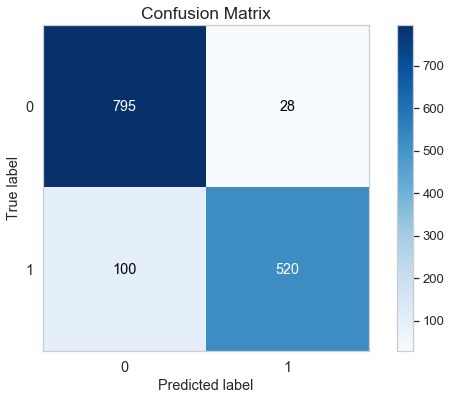

In [5]:
# Logistic Regression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())
print (log_reg,'\n\n')

#prediction
y_pred = log_reg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

we can observe from the classification report that logistic regression performs well . Precision and recall is at 0.91 which is a good measurement considering the best has to be 1 to indicate that all predictions were correctly made.
Details can be view in the confusion matrix were true positives (520) and true negatives (795) have a higher values as compared to False positives (28) and False negatives(100).
This classifier performs well as compared to Compass predictions.

<h4>2. Support Vector Machine</h4>
Support vector machine algorithm is used to find hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points to get nearly accurate predictions.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


classification report 
               precision    recall  f1-score   support

    No Recid       0.89      0.96      0.92       823
       Recid       0.94      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9106029106029107


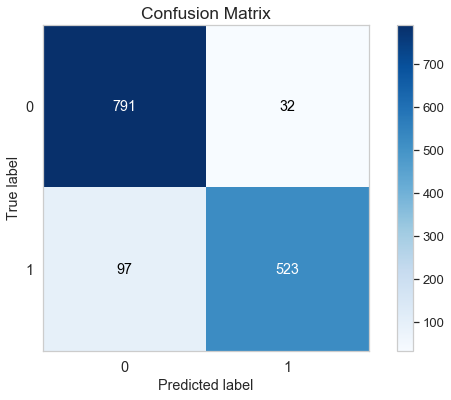

In [6]:
clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train.values.ravel())
print (clfsvm,'\n\n')

#prediction
y_pred = clfsvm.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

we can see from the classification report that precision and recall stands at 0.91 which is a good indication of the classifier. We can say the performance is almost equal with logitic regression. Confusion matrix presents true positives (523) and true negatives (795) have a higher values as compared to False positives (32) and False negatives(97). comparing with Logistic regression, the predictions variations is very negligible. This classifier also performs better than COMPAS predictions.


<h4>3. Decision Tree Classifier </h4>
Decision tres work more like an if-else consition. It split the data and continuously splits based on the features available .until it reaches the lowers point or a leaf.

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 


classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.93      0.90       823
       Recid       0.90      0.82      0.85       620

    accuracy                           0.88      1443
   macro avg       0.88      0.87      0.88      1443
weighted avg       0.88      0.88      0.88      1443

Overall Accuracy :  0.8801108801108801


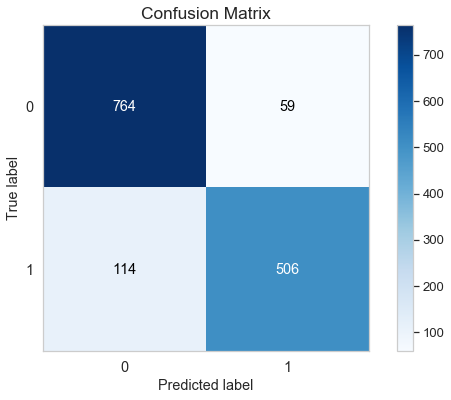

In [7]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print (clf,'\n\n')

#prediction
y_pred = clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

For decision trees, we can see our performance matrix have reduced to 0.88 as compared to SVM and logistic regression. One problem of decision trees is that it can create over-complex trees that do not generalize the data well for accurate predictions and also small variations in the data might result in a different tree being generated. This also affects the prediction.

But from above we can see that the performance metric is quite ok. the predictions are also not far from SVM and logistic regression. we have true positives (509) and true negatives (763) have a higher values as compared to False positives (60) and False negatives(111). This classifier also outperforms COMPAS predictions in this case.

<h4>4. K Nearest Neighbors </h4>

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform') 


classification report 
               precision    recall  f1-score   support

    No Recid       0.86      0.92      0.89       823
       Recid       0.88      0.80      0.84       620

    accuracy                           0.87      1443
   macro avg       0.87      0.86      0.86      1443
weighted avg       0.87      0.87      0.87      1443

Overall Accuracy :  0.8669438669438669


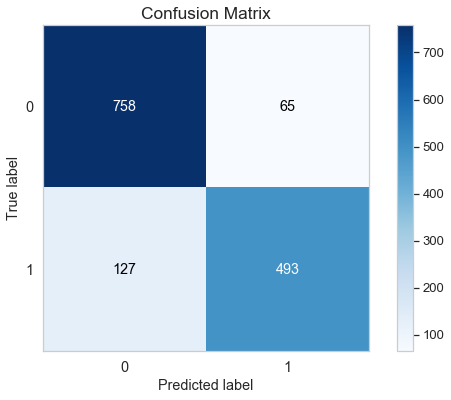

In [8]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.values.ravel())
print (neigh,'\n\n')

#prediction
y_pred = neigh.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

From the performance metrics, K nearest neighbours also performs less as compared to Logistic Regression and SVM. 
using this has increase the number of misclassifications as compared to Decision trees even though the accuracy is almost performance metric is almost same (0.87).
we have true positives (493) and true negatives (758) have a higher values as compared to False positives (65) and False negatives(127).

<h4>5. Neural Network </h4>
In order to train the neural network we will have to split the data training again to get validation set. We then need to convert them into a tensor to be able to train and test with Pytorch.

In [9]:
#splitting the data
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# conversion to tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_testnet = torch.from_numpy(X_test.to_numpy()).float()
y_testnet = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_testnet.shape) +", "+ str(y_testnet.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))

Training	 :torch.Size([5193, 10]), torch.Size([5193])
Testing		 :torch.Size([1443, 10]), torch.Size([1443])
Validation	 :torch.Size([578, 10]), torch.Size([578])


#### First Model
Our first model will use simple architecture of neural network which has 3 convolutional layers. A batch size of 100, learning rate of 0.001

firstmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.682, Acc: 0.652 	|| Validation : - Loss: 0.681, Acc: 0.628
epoch {50} 	==> Train : - Loss: 0.353, Acc: 0.88 	|| Validation : - Loss: 0.315, Acc: 0.9
epoch {100} 	==> Train : - Loss: 0.344, Acc: 0.88 	|| Validation : - Loss: 0.306, Acc: 0.901
epoch {150} 	==> Train : - Loss: 0.336, Acc: 0.891 	|| Validation : - Loss: 0.304, Acc: 0.901
epoch {200} 	==> Train : - Loss: 0.339, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.901
epoch {250} 	==> Train : - Loss: 0.34, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.903
epoch {300} 	==> Train : - Loss: 0.34, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.901
epoch {350} 	==> Train : - Loss: 0.339, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.903

 classification report 
               precision    recall  f1-score 

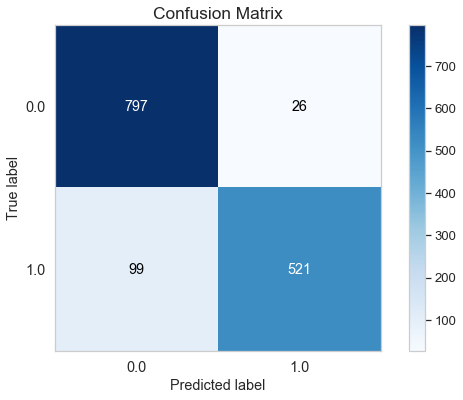

In [10]:
# Defining the model #1
class firstmodel(nn.Module):
  def __init__(self, n_features):
    super(firstmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net1 = firstmodel(X_train.shape[1])
print(net1)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net1(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net1(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net1(X_testnet)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_testnet = y_testnet.cpu()
print('\n classification report \n', classification_report(y_testnet, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testnet, y_pred)))
skplt.metrics.plot_confusion_matrix(y_testnet, y_pred)


The performance metrics for this model stands at 0.92 which is a little improvement as compared to the previous classifiers. we have true positives (520) and true negatives (801) have a higher values as compared to False positives (22) and False negatives(100). This first neural network model also outperforms COMPAS predictions in this case.

### Second model
In this model we added more layers and neurons. We also try to use different activation function(tanh).

secondmodel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.639, Acc: 0.609 	|| Validation : - Loss: 0.623, Acc: 0.663
epoch {50} 	==> Train : - Loss: 0.325, Acc: 0.891 	|| Validation : - Loss: 0.288, Acc: 0.9
epoch {100} 	==> Train : - Loss: 0.331, Acc: 0.891 	|| Validation : - Loss: 0.295, Acc: 0.9
epoch {150} 	==> Train : - Loss: 0.323, Acc: 0.891 	|| Validation : - Loss: 0.296, Acc: 0.9
epoch {200} 	==> Train : - Loss: 0.32, Acc: 0.891 	|| Validation : - Loss: 0.296, Acc: 0.9
epoch {250} 	==> Train : - Loss: 0.317, Acc: 0.891 	|| Validation : - Loss: 0.296, Acc: 0.901
epoch {300} 	==> Train : - Loss: 0.315, Acc: 0.891 	|| Validation : - Loss: 0.3, Acc: 0.896
epoch {350} 	==> Train : - Loss: 0.312, Acc: 0.891 	|| Validation : - Loss: 0.304, Acc: 0.896

 clas

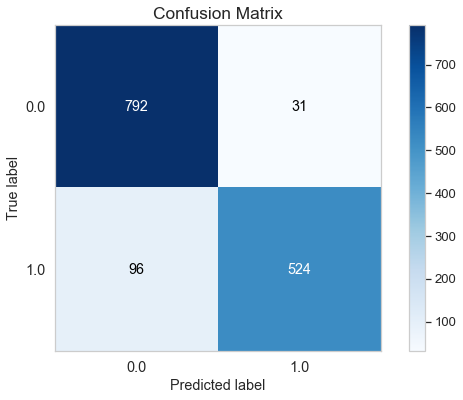

In [11]:
# Defining the model  #2
# Adding layers and neurons
class secondmodel(nn.Module):

  def __init__(self, n_features):
    super(secondmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 20)
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net = secondmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net(X_testnet)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_testnet = y_testnet.cpu()
print('\n classification report \n', classification_report(y_testnet, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testnet, y_pred)))
skplt.metrics.plot_confusion_matrix(y_testnet, y_pred)

from the two models described, we can see they perform almost equally but model 2 outperforms the first model by a difference in accuarcy of 0.003. there is also slight variation in the classifications based ont the confusion matrixes.
we have true positives (527) and true negatives (793) have a higher values as compared to False positives (30) and False negatives(93)
From both model, we can conclude that the performance is almost equal as the other classifiers we described above.

Model 2 outperforms model 1 looking as the confusion matrix values. Both models also outperform the COMPASS prediction.

Looking at the performance metrics of all our classifiers, they actually perform better compared to compass mode of prediction. We will recommend to use Logitic rgression, SVM or Neural networks to for the classification and prediction (based on the performances of our networks).

## 2.3 Feature Sets
According to Probublica's Analysis, they use features including severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years to predict recidivism.

In our case we used the following for our prediction so far;
            
            sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
         'c_charge_degree','is_violent_recid', 'v_decile_score', 'event','two_year_recid'

We want to determine in this section which features amongst our selected ones actually has an effect on the prediction. this will inform us the feature set that are really important to use in our subsequent sections.
for this section, we use use the logistic regression classifier we define above to determine the important feature  sets.

Our approach is to remove one feature set at a time and observe performance while maintaining our ground tuth as 'two_year_recid'

In [12]:
dfnew = df
dfnew.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


<b>1.</b> Firstly, we remove 'v_decile_score' and 'is_violent_recid' from the features to analyse the performance

In [13]:
X_new = dfnew[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.88      0.96      0.92       823
       Recid       0.94      0.82      0.88       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


we can see from the classification report that removing 'v_decile_score' and 'is_violent_recid' from the feature set does not really affect the peformance of the classifier. Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91

<b>2.</b> In the next part we remove 'juv_fel_count' and 'c_charge_degree' in addition to the previously removed features to analyse the performance.

In [14]:
X_new = dfnew[['sex','age_cat', 'race', 'juv_misd_count', 'priors_count', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.97      0.92       823
       Recid       0.95      0.81      0.88       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9015939015939016


we can see from the classification report that removing 'juv_fel_count' and 'c_charge_degree' also does not have much effect on the peformance of the classifier. 
Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91. we still need to remove more features to determine the needed features.

<b>3.</b> in the next part we remove 'sex','age_cat'and 'juv_misd_count' in addition to previously removed features

In [15]:
X_new = dfnew[[ 'race', 'priors_count', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.97      0.92       823
       Recid       0.95      0.81      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443

Overall Accuracy :  0.8995148995148995


Again Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.89 as compared to the original set which gave us 0.91. Performance is actually still good in this regard. We still need to remove more features to determine the needed features.

<b>4.</b> in the next part we remove 'priors_count' 

In [16]:
X_new = dfnew[['race', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.98      0.92       823
       Recid       0.96      0.80      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


Again Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91. 
Performance is actually still good in this regard. We still need to remove more features to determine the needed features.

<b>4.</b> in the next part we remove 'event' 

In [17]:
X_new = dfnew[[ 'race']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.56      0.93      0.70       823
       Recid       0.33      0.04      0.08       620

    accuracy                           0.55      1443
   macro avg       0.45      0.49      0.39      1443
weighted avg       0.46      0.55      0.43      1443

Overall Accuracy :  0.5509355509355509


we can see that removing event and only considering race, overall accuracy now stands at 0.55 which is pretty bad. This tells us that the 'event' feature is necessary to give us an accurate prediction

<b>5.</b> in the next part we remove 'race' 

In [18]:
#removing v_decile_score, is violent recid, c_charge_degree, juv_misd_count, juv_fel_count, age_cat, prior_count, sex
X_new = dfnew[[ 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.98      0.92       823
       Recid       0.96      0.80      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


we can see that using the 'event' set alone gives us a good accuracy of 0.90. we can now conclude that event is one of the feature sets necessary for correct prediction.
using event alone gives us the same accuracy as using 'event' and 'race' feature

### Features to Use
##### not sure - From our analysis, we recommend using the 'event' in addition to any other feature set for the classification or prediction to be almost accurate.

## 2.4 Fairness
We will investigate the fairness of each classifier with the notion of Independence and seperation.

### 2.4.1 Independence
According to the book. To satisfy independence simply requires that the sensitive characteristic to be statistically independent of the scores recorded. Independence condition requires the acceptance rate to be the same in all groups to be considered.

### 2.4.2 Seperation
Separation allows correlation between the score and the sensitive attribute to the extent that it is justified by the target variable.

Since race is a sensitive feature, we will observe independence for particularly 'African-American' compared to all other races. we will use all our predifined classifiers to observe this notion of fairness. We will also observe this on gender as well.

Therefore first we will have to filter the dataframe according to race and sex.

In [19]:
# filtering according to African-American
Xfair1 = X_test.loc[df['race'] == 2]
yfair1 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]

Xfair2 = X_test.loc[df['race'] != 2]
yfair2 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]

# filtering according to sex
Xfair3 = X_test.loc[df['sex'] == 1]
yfair3 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]

Xfair4 = X_test.loc[df['sex'] == 2]
yfair4 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]

#### Logistic Regression

In [20]:
print(">> Race ===>")
y_pred = log_reg.predict(Xfair1)
#relabelling confusion matrix and calculating tpr and fpr
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0]) 
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = log_reg.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

#independence ratio
independence1 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence1 = Pfair2_true/Pfair1_true

#tpr and fpr ratio according to seperation  
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf1r = fpr1/fpr2
if sepf1r>1:
    sepf1r = fpr2/fpr1
    
print("-- Indepence (Ratio) \t\t = " + str(round(independence1,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf1r,3)) )


print("\n>> Gender ===>")
y_pred = log_reg.predict(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = log_reg.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence1g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence1g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf1g = fpr1/fpr2
if sepf1g>1:
    sepf1g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence1g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf1g,3)) )

>> Race ===>
- African-American =>
True Positive Rate	 = 0.8387096774193549
False Positive Rate	 = 0.052924791086350974
Acceptance rate		 = 0.4528043775649795
- Non African-American =>
True Positive Rate	 = 0.8387096774193549
False Positive Rate	 = 0.01939655172413793
Acceptance rate		 = 0.3047752808988764
-- Indepence (Ratio) 		 = 0.673
-- Separation (TPR Ratio) 	 = 1.0
-- Separation (FPR Ratio) 	 = 0.366

>> Gender ===>
- Males =>
True Positive Rate	 = 0.8429906542056075
False Positive Rate	 = 0.0364741641337386
Acceptance rate		 = 0.39815590947191953
- Females =>
True Positive Rate	 = 0.8117647058823529
False Positive Rate	 = 0.024242424242424242
Acceptance rate		 = 0.292
-- Independence (Ratio) 	 = 0.733
-- Separation (TPR Ratio) 	 = 0.963
-- Separation (FPR Ratio) 	 = 0.665


using Logistic regression, the false positive ratio for race is 0.3 which is not that bad and according to gender its a little high at 0.66. The true positive value is 1 and 0.96 in race and gender respectively, a good indication of fairness. Independence ratio is almost close in gender and race.

#### Support Vector Machine

In [21]:
print(">> Race ===>")
y_pred = clfsvm.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clfsvm.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence2 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence2 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf2r = fpr1/fpr2
if sepf2r>1:
    sepf2r = fpr2/fpr1
    
print("-- Indepence (Ratio) \t\t = " + str(round(independence2,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf2r,3)) )


print("\n>> Gender ===>")
y_pred = clfsvm.predict(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clfsvm.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence2g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence2g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf2g = fpr1/fpr2
if sepf2g>1:
    sepf2g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence2g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf2g,3)) )


>> Race ===>
- African-American =>
True Positive Rate	 = 0.8440860215053764
False Positive Rate	 = 0.0584958217270195
Acceptance rate		 = 0.4582763337893297
- Non African-American =>
True Positive Rate	 = 0.842741935483871
False Positive Rate	 = 0.023706896551724137
Acceptance rate		 = 0.3089887640449438
-- Indepence (Ratio) 		 = 0.674
-- Separation (TPR Ratio) 	 = 0.998
-- Separation (FPR Ratio) 	 = 0.405

>> Gender ===>
- Males =>
True Positive Rate	 = 0.8485981308411215
False Positive Rate	 = 0.0425531914893617
Acceptance rate		 = 0.40402347024308466
- Females =>
True Positive Rate	 = 0.8117647058823529
False Positive Rate	 = 0.024242424242424242
Acceptance rate		 = 0.292
-- Independence (Ratio) 	 = 0.723
-- Separation (TPR Ratio) 	 = 0.957
-- Separation (FPR Ratio) 	 = 0.57


using Support Vector Machine, the false positive ratio for race is 0.4  and according to gender its a little high at 0.57 which is a reduction from the logistic regression classifier. The true positive value is 0.99 and 0.95 in race and gender respectively which is quite good. Independence ratio also differs between race and gender by 0.1.

#### Decision Trees

In [22]:
print(">> Race ===>")
y_pred = clf.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clf.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence3 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence3 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf3r = fpr1/fpr2
if sepf3r>1:
    sepf3r = fpr2/fpr1
    
print("-- Indepence (Ratio) \t\t = " + str(round(independence3,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf3r,3)) )



print("\n>>Gender ===>")
y_pred = clf.predict(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clf.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence3g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence3g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf3g = fpr1/fpr2
if sepf3g>1:
    sepf3g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence3g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf3g,3)) )


>> Race ===>
- African-American =>
True Positive Rate	 = 0.8252688172043011
False Positive Rate	 = 0.08635097493036212
Acceptance rate		 = 0.46238030095759236
- Non African-American =>
True Positive Rate	 = 0.8024193548387096
False Positive Rate	 = 0.0603448275862069
Acceptance rate		 = 0.3188202247191011
-- Indepence (Ratio) 		 = 0.69
-- Separation (TPR Ratio) 	 = 0.972
-- Separation (FPR Ratio) 	 = 0.699

>>Gender ===>
- Males =>
True Positive Rate	 = 0.8205607476635514
False Positive Rate	 = 0.0668693009118541
Acceptance rate		 = 0.40486169321039395
- Females =>
True Positive Rate	 = 0.788235294117647
False Positive Rate	 = 0.09090909090909091
Acceptance rate		 = 0.328
-- Independence (Ratio) 	 = 0.81
-- Separation (TPR Ratio) 	 = 0.961
-- Separation (FPR Ratio) 	 = 0.736


Considering Decision trees classifier, the false positive ratio for race is 0.7 and according to gender is 0.64 which are both actually high. 

#### K Nearest Neighbors

In [23]:
print(">> Race ===>")
y_pred = neigh.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = neigh.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence4 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence4 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf4r = fpr1/fpr2
if sepf4r>1:
    sepf4r = fpr2/fpr1
    
print("-- Indepence (Ratio) \t\t = " + str(round(independence4,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf4r,3)) )


print("\n>>Gender ===>")
y_pred = neigh.predict(Xfair3)
Pfair3_true = np.sum(y_pred) / len(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = neigh.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence4g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence4g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf4g = fpr1/fpr2
if sepf4g>1:
    sepf4g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence4g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf4g,3)) )


>> Race ===>
- African-American =>
True Positive Rate	 = 0.8010752688172043
False Positive Rate	 = 0.10863509749303621
Acceptance rate		 = 0.46101231190150477
- Non African-American =>
True Positive Rate	 = 0.7862903225806451
False Positive Rate	 = 0.05603448275862069
Acceptance rate		 = 0.3103932584269663
-- Indepence (Ratio) 		 = 0.673
-- Separation (TPR Ratio) 	 = 0.982
-- Separation (FPR Ratio) 	 = 0.516

>>Gender ===>
- Males =>
True Positive Rate	 = 0.8037383177570093
False Positive Rate	 = 0.08662613981762918
Acceptance rate		 = 0.4082145850796312
- Females =>
True Positive Rate	 = 0.7411764705882353
False Positive Rate	 = 0.048484848484848485
Acceptance rate		 = 0.284
-- Independence (Ratio) 	 = 0.696
-- Separation (TPR Ratio) 	 = 0.922
-- Separation (FPR Ratio) 	 = 0.56


In K Nearest Neighbors, the false positive ratio in both race and gender is almost equal but the value is not good. Meaning a significant number of people can still be wrongly convicted. but it performs well on the true-positive rate.
#### Neural Network

In [24]:
print(">> Race ===>")
Xfair1net = torch.from_numpy(Xfair1.to_numpy()).float()
y_pred = net(Xfair1net)
y_pred = y_pred.ge(.5).view(-1).cpu()
# yfair1 = yfair1.cpu
# Xfair1 = Xfair1.cpu
# Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair2net = torch.from_numpy(Xfair2.to_numpy()).float()
y_pred = net(Xfair2net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/ len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf5r = fpr1/fpr2
if sepf5r>1:
    sepf5r = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5r,3)) )


print("\n>>Gender ===>")
Xfair3net = torch.from_numpy(Xfair3.to_numpy()).float()
y_pred = net(Xfair3net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0]) / len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair4net = torch.from_numpy(Xfair4.to_numpy()).float()
y_pred = net(Xfair4net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0]) / len(Xfair4)

print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf5g = fpr1/fpr2
if sepf5g>1:
    sepf5g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5g,3)) )

>> Race ===>
- African-American =>
True Positive Rate	 = 0.8494623655913979
False Positive Rate	 = 0.052924791086350974
Acceptance rate		 = 0.4582763337893297
- Non African-American =>
True Positive Rate	 = 0.8387096774193549
False Positive Rate	 = 0.02586206896551724
Acceptance rate		 = 0.3089887640449438
-- Independence (Ratio) 	 = 0.674
-- Separation (TPR Ratio) 	 = 0.987
-- Separation (FPR Ratio) 	 = 0.489

>>Gender ===>
- Males =>
True Positive Rate	 = 0.8494623655913979
False Positive Rate	 = 0.052924791086350974
Acceptance rate		 = 0.40234702430846603
- Females =>
True Positive Rate	 = 0.8235294117647058
False Positive Rate	 = 0.030303030303030304
Acceptance rate		 = 0.3
-- Independence (Ratio) 	 = 0.746
-- Separation (TPR Ratio) 	 = 0.969
-- Separation (FPR Ratio) 	 = 0.573


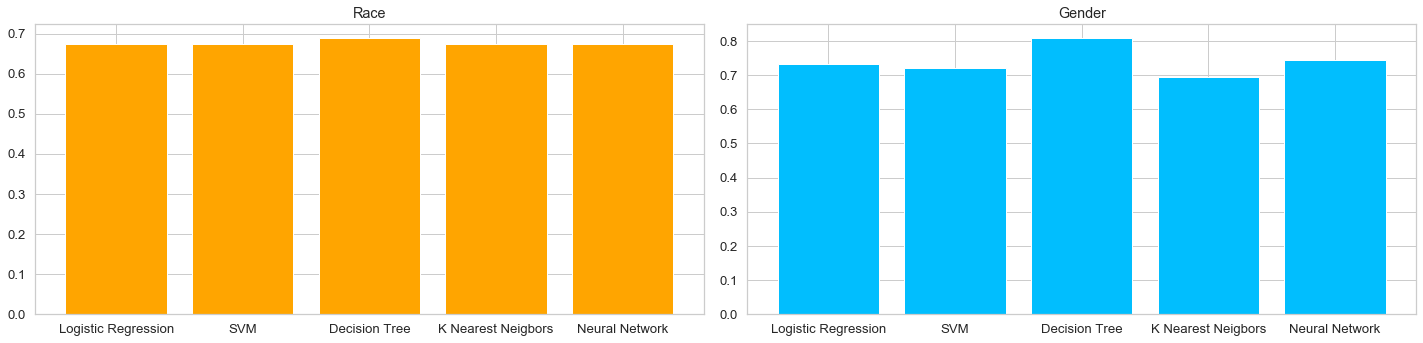

In [25]:
bottom = ["Logistic Regression", "SVM", "Decision Tree", "K Nearest Neigbors", "Neural Network"]
left = [independence1, independence2, independence3, independence4, independence5]
leftg = [independence1g, independence2g, independence3g, independence4g, independence5g]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].set_title('Race')
axes[0].bar(bottom, left, color='orange')
axes[1].set_title('Gender')
axes[1].bar(bottom, leftg)
fig.tight_layout()

As we can see from the result above there is not much difference between classifiers. We will consider the best one and combine the results on performance analysis, and the feature sets.

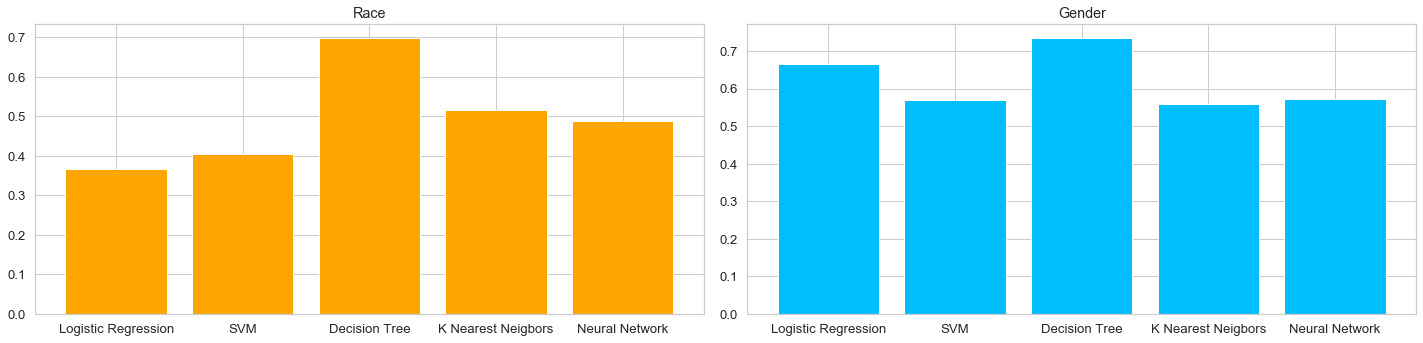

In [26]:
bottom = ["Logistic Regression", "SVM", "Decision Tree", "K Nearest Neigbors", "Neural Network"]
RaceFP = [sepf1r, sepf2r, sepf3r, sepf4r, sepf5r]
GenderFP = [sepf1g, sepf2g, sepf3g, sepf4g, sepf5g]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].set_title('Race')
axes[0].bar(bottom, RaceFP, color='orange')
axes[1].set_title('Gender')
axes[1].bar(bottom, GenderFP)
fig.tight_layout()